### Imports

In [1]:
## filter the warnings
import warnings
warnings.filterwarnings('ignore')

import os
import random
import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn as nn
import torch.nn.functional as F

import timm

from sklearn.metrics import roc_auc_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

np.random.seed(10)
torch.manual_seed(10)

### Data Loading and Pre-Processing

In [2]:
## I am iterating over each folder within the specified path and for each subfolder within each folder I am looping over each image file 
# and append its path to the appropriate lists (training and validation) along with its corresponding labels

folders = glob.glob('/kaggle/input/dataset1/dataset/*')

train_images, train_labels = [], []
val_images, val_labels = [], []

label_2_idx_dict = {'no' : 0, 'vort' : 1, 'sphere' : 2}
idx_2_label_dict = {0 : 'no', 1 : 'vort', 2: 'sphere'}

## no -> 0   vort -> 1   sphere -> 2

for folder in sorted(folders):
  for subfolder in glob.glob(folder+'/*'):

    for img in glob.glob(subfolder+'/*'):
      
      if(subfolder.split('/')[-2] == 'train'):
        train_images.append(img)
        train_labels.append(label_2_idx_dict[subfolder.split('/')[-1]])
      
      elif(subfolder.split('/')[-2] == 'val'):
        val_images.append(img)
        val_labels.append(label_2_idx_dict[subfolder.split('/')[-1]])

      else:
        break

In [3]:
## Creating a DataFrame from the above created list (I kinda find it easy to work with pandas DataFrame!!)

train_data = pd.DataFrame({
    'image' : train_images,
    'labels' : train_labels
})

val_data = pd.DataFrame({
    'image' : val_images,
    'labels' : val_labels
})

In [4]:
train_data

,image,labels
0,/kaggle/input/dataset1/dataset/train/no/5955.npy,0
1,/kaggle/input/dataset1/dataset/train/no/4548.npy,0
2,/kaggle/input/dataset1/dataset/train/no/5788.npy,0
3,/kaggle/input/dataset1/dataset/train/no/6947.npy,0
4,/kaggle/input/dataset1/dataset/train/no/8600.npy,0
...,...,...
29995,/kaggle/input/dataset1/dataset/train/sphere/32...,2
29996,/kaggle/input/dataset1/dataset/train/sphere/17...,2
29997,/kaggle/input/dataset1/dataset/train/sphere/54...,2
29998,/kaggle/input/dataset1/dataset/train/sphere/81...,2


In [5]:
## Checking if there is any class imbalance.
print(train_data.labels.value_counts())

0    10000
1    10000
2    10000
Name: labels, dtype: int64


In [6]:
## Splitting the train set that I have into train and test set with test size 10% of the train set
train_df, test_df = train_test_split(train_data, test_size=0.1, random_state=10)
val_df = val_data

In [7]:
train_df.shape

(27000, 2)

Plotting the Images

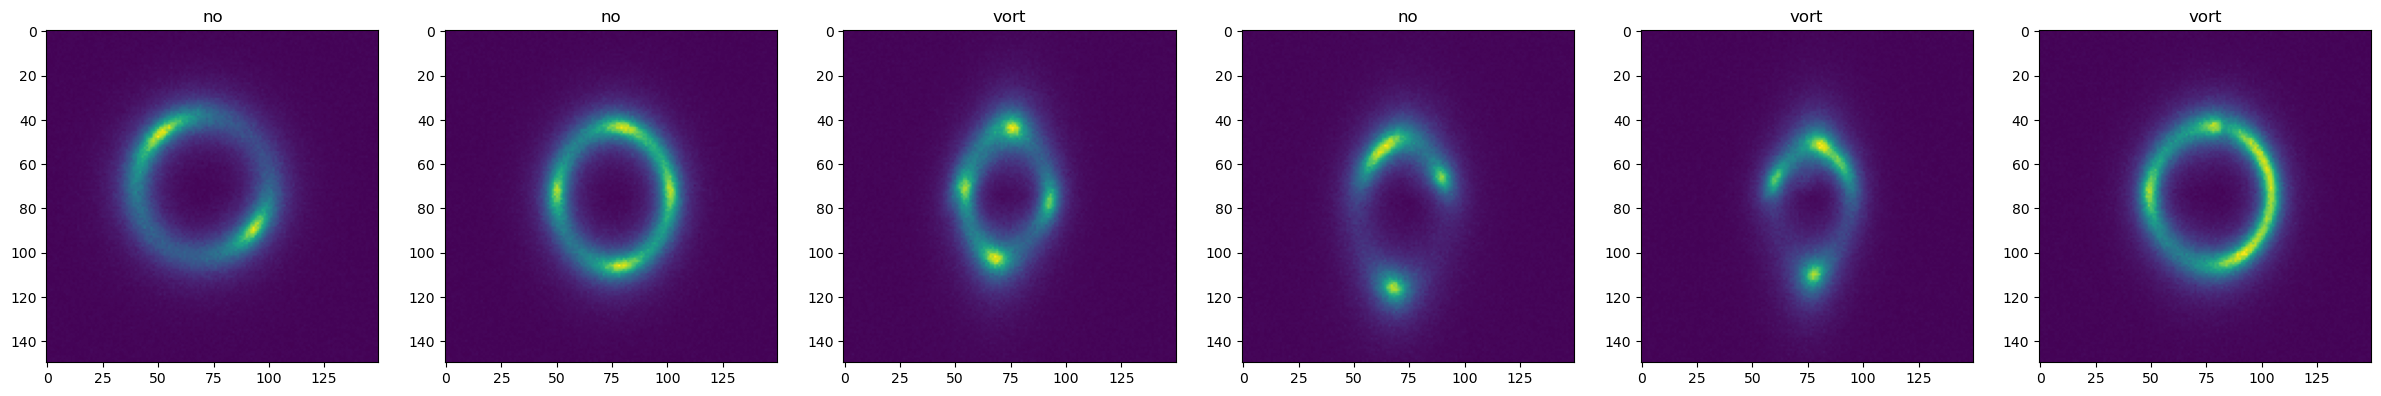

In [8]:
fig, ax = plt.subplots(1, 6)
fig.set_figheight(30)
fig.set_figwidth(30)
for i in range(6):
  idx = np.random.randint(0, train_df.shape[0])
  img_arr = np.load(str(train_df.iloc[idx]['image']))
  ax[i].imshow(img_arr.T)
  title = idx_2_label_dict[train_df.iloc[idx]['labels']]
  ax[i].set_title(title)

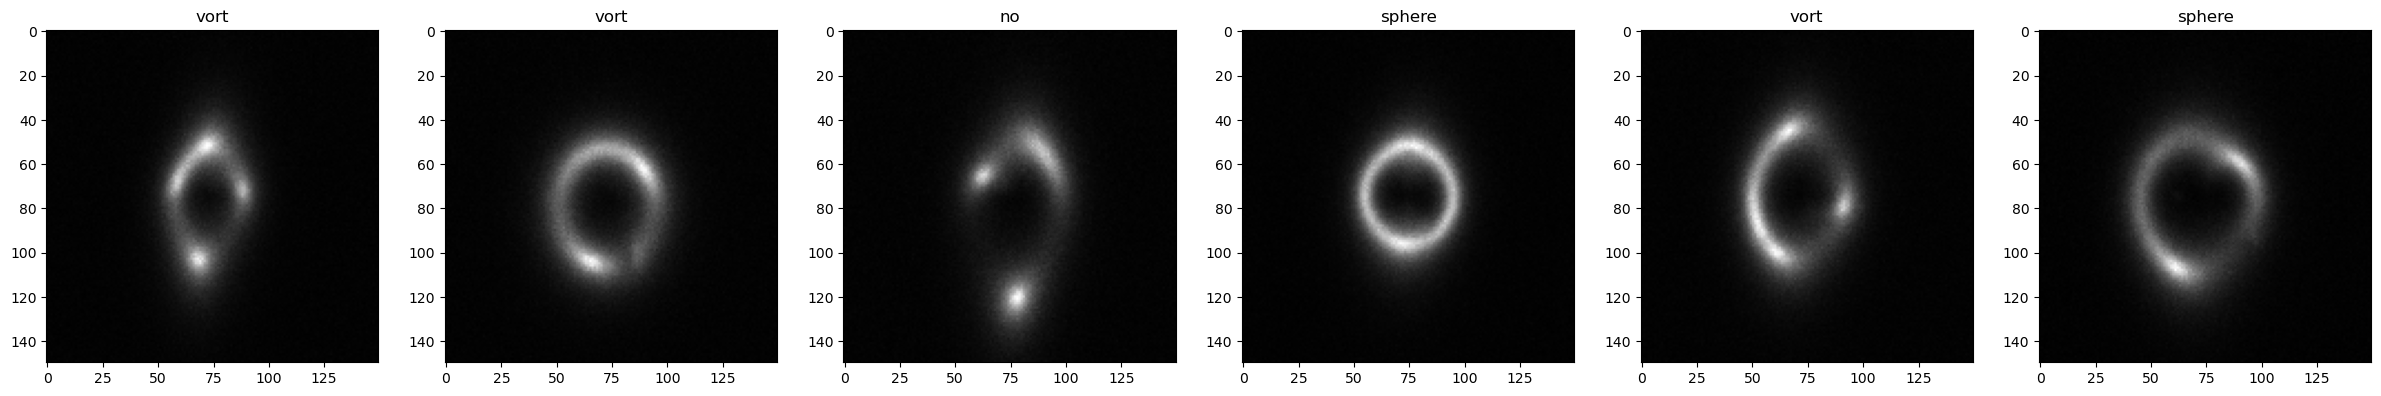

In [9]:
fig, ax = plt.subplots(1, 6)
fig.set_figheight(30)
fig.set_figwidth(30)
for i in range(6):
  idx = np.random.randint(0, train_df.shape[0])
  img_arr = np.load(str(train_df.iloc[idx]['image']))
  ax[i].imshow(img_arr.T, cmap='gray')
  title = idx_2_label_dict[train_df.iloc[idx]['labels']]
  ax[i].set_title(title)

Creating the Dataset Class

In [10]:
class CreateDataset(Dataset):
  """
  Creates a PyTorch dataset that can be used for training or testing image classification models.
  It takes in a Pandas DataFrame df containing image paths and their corresponding labels, along with optional transforms for data augmentation, 
  and a boolean is_test flag.
  If is_test is True, it returns only the image. Otherwise, it returns a tuple containing the transformed image and a tensor representing the label, 
  converted to a float32 data type using PyTorch's torch.tensor method.
  
  """

  def __init__(self, df, transforms = None, is_test = False):
    self.df = df
    self.transforms = transforms
    self.is_test = is_test

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, idx):
    img = np.load(self.df.iloc[idx]['image'])  ## The images are in .npy format, so I used numpy to load the images

    if self.transforms:
        aug = self.transforms(image=img.T)
        img = aug['image']

    if self.is_test:
      return img
    else:
      labels = torch.tensor([self.df.iloc[idx]['labels']], dtype = torch.float32)

      return img, labels

Augmentations:
I have tried experimenting with various augmentations but only the AdvanceBlur method seems to work well with my approach

In [11]:
## Using the Albumentations library here for applying data augmentations
train_transform = A.Compose([
    A.AdvancedBlur(
    blur_limit=(3, 7), sigmaX_limit=(0.2, 1.0), sigmaY_limit=(0.2, 1.0), rotate_limit=90, beta_limit=(0.5, 8.0),
    noise_limit=(0.9, 1.1), always_apply=False, p=0.35
    ),
    ToTensorV2()
])

test_transform = A.Compose([
    ToTensorV2()
])

Creating the Dataset

In [12]:
train_ds = CreateDataset(train_df, transforms=train_transform)
val_ds = CreateDataset(val_df, transforms=test_transform)
test_ds = CreateDataset(test_df, transforms=test_transform)
len(train_ds), len(val_ds), len(test_ds)

(27000, 7500, 3000)

In [13]:
BATCH_SIZE = 64

## Pytorch standard DataLoader function, which creates PyTorch data loaders for the training, validation, and test datasets,
#  which can be used to load batches of data for training or testing machine learning models.
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4,pin_memory=True,drop_last=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE,shuffle=False, num_workers=4,pin_memory=True, drop_last=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4,pin_memory=True, drop_last=False) 

### The MODEL

I have used the timm library to get the backbone architecture for the model. I experimented with several models but 'efficientnet_b3' gave me the best results. The model is initialized with the pretrained weights and as the images are grayscale images so 'in_chans=1' handles that part.

I have customized the model by adding few layers on top of the backbone model. I have created a Convolutional block to increase the model's representational power and improve its ability to capture important features in the data. The output from the backbone model is passed through this block. Then I decided to further add a Residual Connection in the network, this helps to improve the flow of information through the network and prevent the vanishing gradient problem, which can occur in very deep neural networks The output of the convolutional block is added to the output of the residual block. After this the output is passed through ReLU activation function, then flattened it and then finally pass it through the fully connected classifier to generate the final output. The final output is a vector of length 3, representing the model's prediction for the input image's class probabilities.

I used PReLU activation function in the convolutional and fully connected blocks. It is similar to the ReLU function, but with a small slope for negative inputs, which can help alleviate the "dying ReLU" problem where some neurons can become stuck at zero and stop learning. The dropout layers are also added to reduce overfitting.

In [17]:
class my_model(nn.Module):
    
    def __init__(self, pretrained=True):
        super().__init__()
        self.model = timm.create_model('efficientnet_b3', pretrained=pretrained, in_chans=1) ## creating the backbone model
        
        for param in self.model.parameters():   ## Training the whole model without any freezing of layers
            param.requires_grad = True
        
        self.conv_block = nn.Sequential(
                                nn.Conv2d(1536, 512, kernel_size=3, padding=1),
                                nn.BatchNorm2d(512),
                                nn.PReLU(),
                                nn.Dropout2d(p=0.5),
                                nn.Conv2d(512, 128, kernel_size=3, padding=1),
                                nn.BatchNorm2d(128),
                                nn.PReLU(),
                                nn.Dropout2d(p=0.3),
                                nn.Conv2d(128, 64, kernel_size=3, padding=1),
                                nn.BatchNorm2d(64),
                                nn.PReLU(),
                                nn.Dropout2d(p=0.1)
        )
        
        self.residual_block = nn.Sequential(
                                nn.Conv2d(1536, 64, kernel_size=1),
                                nn.BatchNorm2d(64),
        )
        
        self.fc = nn.Sequential(
                                nn.Linear(64 * 5 * 5, 128),
                                nn.PReLU(),
                                nn.BatchNorm1d(128),
                                nn.Dropout(p=0.2),
            
                                nn.Linear(128, 3)
                                )
        
    def forward(self, x):
        x = self.model.forward_features(x)  ## Getting the features from the backbone model
        
        residual = x  ## storing the value to use later
        
        x = self.conv_block(x)
        x += self.residual_block(residual)  ## Adding the conv block output with the residual block output
        x = F.relu(x)
        
        x = x.view(-1, 64 * 5 * 5)  ## Flatten so that it can be passed to the fully connected layers
        x = self.fc(x)  ## Final output
        
        return x


In [18]:
model = my_model()

In [19]:
## checking if the model is working correctly
x = torch.randn(BATCH_SIZE, 1, 150, 150)
print(model(x).shape)

torch.Size([64, 3])


### Training

In [20]:
## Setting the Device to CUDA if GPU is available else CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


Loss Function -

When I trained the model with the normal Cross Entropy loss I found that my model was overfitting a lot. So I learnt about Label Smoothing technique (https://towardsdatascience.com/what-is-label-smoothing-108debd7ef06) and it reduced the overfitting to some extent. 

In standard cross entropy, the true label is assigned a probability of 1, and all other labels are assigned a probability of 0. This can lead to overfitting in some cases, especially when the model is confident in its predictions. Label smoothing is a technique that addresses this problem by replacing the hard targets (0s and 1s) with soft targets that assign some probability to incorrect labels.

The label smoothing cross entropy loss function penalizes the model less harshly for making confident but incorrect predictions, which can improve the model's generalization performance. The amount of smoothing is controlled by a hyperparameter called the smoothing factor, which determines the extent to which the model should trust its predictions.

In [24]:
smoothing_factor = 0.2
def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε:float=smoothing_factor, reduction='mean'):
        super().__init__()
        self.ε,self.reduction = ε,reduction
    
    def forward(self, output, target):
        # number of classes
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        # (1-ε)* H(q,p) + ε*H(u,p)
        return (1-self.ε)*nll + self.ε*(loss/c) 

Calculate Accuracy Function

In [25]:
def calculate_accuracy(labels, logits):
    logits_softmax = torch.log_softmax(logits, dim = 1)
    _, preds = torch.max(logits_softmax, dim = 1)
    correct_train = (labels.squeeze() == preds).sum().item()
    acc = (100 * correct_train) / BATCH_SIZE
    
    return acc

#### Training and Validation Loop

One trick I learnt from one of my senior, for the first few epochs train the model using the normal CrossEntropy Loss to make the model more confident. After that use LabelSmoothing so that it works as a Regularization method. This gave me the best results out of all the experiments I performed

In [26]:
def train_model(model,
                train_dataloader,
                val_dataloader,
                dataset_size, 
                val_dataset_size,
                optimizer, 
                scheduler, 
                num_epochs):
    
    model = model.to(device)
    
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []

    criterion1 = nn.CrossEntropyLoss()
    criterion2 = LabelSmoothingCrossEntropy()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        ############## TRAINING ###############
        model.train()

        running_loss = 0.0
        running_acc = 0.0
        
        ## The training trick!!
        if (epoch < 4):
            criterion = criterion1
        else:
            criterion = criterion2
            
        
        # Iterate over data.
        for batch in tqdm(train_dataloader):
            inputs = batch[0]
            labels = batch[1].squeeze()
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)
            
            outputs = model(inputs) ## ->(64,3)
                
            acc = calculate_accuracy(labels = labels, logits = outputs)
            
            loss = criterion(outputs, labels.to(device, dtype=torch.int64)) ## Was throwing some error so had to convert it to int

            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss
            running_acc += acc
        
        epoch_loss = running_loss / dataset_size
        epoch_acc = running_acc / dataset_size
        train_acc.append(epoch_acc)
        train_loss.append(epoch_loss.cpu().detach().numpy())
        print('Train Loss: {:.4f} --- Train Accuracy: {:.4f}'.format(epoch_loss, epoch_acc))
        
        ############# VALIDATION #############
        model.eval()
        
        running_val_loss, running_val_acc = 0.0, 0.0
        
        for batch in tqdm(val_dataloader):
            inputs, labels = batch[0], batch[1].squeeze()
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)
            
            with torch.no_grad():
                outputs = model(inputs)
  
            acc = calculate_accuracy(labels = labels, logits = outputs)
            loss = criterion(outputs, labels.to(device, dtype=torch.int64))
    
            running_val_loss  += loss
            running_val_acc += acc

        epoch_val_loss = running_val_loss / val_dataset_size
        epoch_val_acc = running_val_acc / val_dataset_size
        
        val_acc.append(epoch_val_acc)
        val_loss.append(epoch_val_loss.cpu().detach().numpy())
        print('Val Loss: {:.4f} --- Val Accuracy: {:.4f}\n'.format(epoch_val_loss, epoch_val_acc))
        
        scheduler.step()  ## The learning rate scheduler step
        
    print(f"\n\nTotal Training Loss: {sum(train_loss) / num_epochs} ---- Total Training Accuracy: {sum(train_acc) / num_epochs}")
    print(f"Total Validation Loss: {sum(val_loss) / num_epochs} --- Total Validation Accuracy: {sum(val_acc) / num_epochs}\n")
    
    return model, train_acc, train_loss, val_acc, val_loss

I found the AdamW optimizer to give the best results. I used it because my model was overfitting with other optimizers and the AdamW optimizer is a variation of the popular Adam optimizer, which incorporates weight decay regularization into the optimization process to prevent overfitting. 

I also used Cosine Annealing with Warm Restarts as my learning rate scheduler. It is a learning rate scheduler that reduces the learning rate of the optimizer at specific intervals during training.


In [27]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

training_epochs = 30
optimizer = optim.AdamW(model.parameters(),lr=2e-3, weight_decay=1e-6)
lr_sch = CosineAnnealingWarmRestarts(optimizer, T_0 = 15, eta_min = 1e-7, verbose = True)

model = model.to(device)

model_ft, train_acc, train_loss, val_acc, val_loss = train_model(model,
                                                                 train_dl,
                                                                 val_dl,
                                                                 len(train_dl),
                                                                 len(val_dl),
                                                                 optimizer,
                                                                 lr_sch,
                                                                 num_epochs=training_epochs)

Epoch 00000: adjusting learning rate of group 0 to 2.0000e-03.
Epoch 0/29
----------


100%|██████████| 421/421 [03:11<00:00,  2.20it/s]


Train Loss: 1.1233 --- Train Accuracy: 33.5177


100%|██████████| 118/118 [00:14<00:00,  8.14it/s]


Val Loss: 3.0428 --- Val Accuracy: 33.8189

Epoch 00001: adjusting learning rate of group 0 to 1.9781e-03.
Epoch 1/29
----------


100%|██████████| 421/421 [03:12<00:00,  2.19it/s]


Train Loss: 1.1113 --- Train Accuracy: 33.6290


100%|██████████| 118/118 [00:14<00:00,  8.41it/s]


Val Loss: 1.2286 --- Val Accuracy: 32.7198

Epoch 00002: adjusting learning rate of group 0 to 1.9135e-03.
Epoch 2/29
----------


100%|██████████| 421/421 [03:09<00:00,  2.23it/s]


Train Loss: 1.1128 --- Train Accuracy: 33.2022


100%|██████████| 118/118 [00:13<00:00,  8.79it/s]


Val Loss: 1.0987 --- Val Accuracy: 33.1435

Epoch 00003: adjusting learning rate of group 0 to 1.8090e-03.
Epoch 3/29
----------


100%|██████████| 421/421 [03:08<00:00,  2.23it/s]


Train Loss: 1.1069 --- Train Accuracy: 32.8125


100%|██████████| 118/118 [00:13<00:00,  8.51it/s]


Val Loss: 1.1113 --- Val Accuracy: 33.1435

Epoch 00004: adjusting learning rate of group 0 to 1.6691e-03.
Epoch 4/29
----------


100%|██████████| 421/421 [03:07<00:00,  2.25it/s]


Train Loss: 1.1042 --- Train Accuracy: 33.5474


100%|██████████| 118/118 [00:13<00:00,  9.01it/s]


Val Loss: 1.0989 --- Val Accuracy: 33.1038

Epoch 00005: adjusting learning rate of group 0 to 1.5000e-03.
Epoch 5/29
----------


100%|██████████| 421/421 [03:10<00:00,  2.21it/s]


Train Loss: 1.1043 --- Train Accuracy: 32.9387


100%|██████████| 118/118 [00:13<00:00,  8.88it/s]


Val Loss: 1.0986 --- Val Accuracy: 33.1038

Epoch 00006: adjusting learning rate of group 0 to 1.3091e-03.
Epoch 6/29
----------


100%|██████████| 421/421 [03:09<00:00,  2.22it/s]


Train Loss: 1.1035 --- Train Accuracy: 33.1985


100%|██████████| 118/118 [00:13<00:00,  8.45it/s]


Val Loss: 1.0986 --- Val Accuracy: 33.1038

Epoch 00007: adjusting learning rate of group 0 to 1.1046e-03.
Epoch 7/29
----------


100%|██████████| 421/421 [03:09<00:00,  2.22it/s]


Train Loss: 1.1022 --- Train Accuracy: 33.9074


100%|██████████| 118/118 [00:13<00:00,  8.74it/s]


Val Loss: 1.0983 --- Val Accuracy: 34.0440

Epoch 00008: adjusting learning rate of group 0 to 8.9553e-04.
Epoch 8/29
----------


100%|██████████| 421/421 [03:08<00:00,  2.23it/s]


Train Loss: 1.1017 --- Train Accuracy: 34.4752


100%|██████████| 118/118 [00:13<00:00,  8.73it/s]


Val Loss: 1.0946 --- Val Accuracy: 36.8247

Epoch 00009: adjusting learning rate of group 0 to 6.9105e-04.
Epoch 9/29
----------


100%|██████████| 421/421 [03:09<00:00,  2.22it/s]


Train Loss: 1.0585 --- Train Accuracy: 43.2044


100%|██████████| 118/118 [00:14<00:00,  8.12it/s]


Val Loss: 0.9725 --- Val Accuracy: 55.1774

Epoch 00010: adjusting learning rate of group 0 to 5.0008e-04.
Epoch 10/29
----------


100%|██████████| 421/421 [03:07<00:00,  2.24it/s]


Train Loss: 0.8591 --- Train Accuracy: 68.1896


100%|██████████| 118/118 [00:13<00:00,  8.59it/s]


Val Loss: 0.7914 --- Val Accuracy: 76.6287

Epoch 00011: adjusting learning rate of group 0 to 3.3095e-04.
Epoch 11/29
----------


100%|██████████| 421/421 [03:07<00:00,  2.24it/s]


Train Loss: 0.6947 --- Train Accuracy: 84.3268


100%|██████████| 118/118 [00:13<00:00,  8.47it/s]


Val Loss: 0.6992 --- Val Accuracy: 84.3353

Epoch 00012: adjusting learning rate of group 0 to 1.9107e-04.
Epoch 12/29
----------


100%|██████████| 421/421 [03:10<00:00,  2.22it/s]


Train Loss: 0.6306 --- Train Accuracy: 89.7157


100%|██████████| 118/118 [00:14<00:00,  8.27it/s]


Val Loss: 0.6399 --- Val Accuracy: 88.1886

Epoch 00013: adjusting learning rate of group 0 to 8.6550e-05.
Epoch 13/29
----------


100%|██████████| 421/421 [03:08<00:00,  2.23it/s]


Train Loss: 0.6003 --- Train Accuracy: 92.0131


100%|██████████| 118/118 [00:13<00:00,  8.43it/s]


Val Loss: 0.6312 --- Val Accuracy: 88.8771

Epoch 00014: adjusting learning rate of group 0 to 2.1951e-05.
Epoch 14/29
----------


100%|██████████| 421/421 [03:08<00:00,  2.23it/s]


Train Loss: 0.5827 --- Train Accuracy: 93.3937


100%|██████████| 118/118 [00:13<00:00,  8.51it/s]


Val Loss: 0.6271 --- Val Accuracy: 89.2346

Epoch 00015: adjusting learning rate of group 0 to 2.0000e-03.
Epoch 15/29
----------


100%|██████████| 421/421 [03:08<00:00,  2.24it/s]


Train Loss: 0.6815 --- Train Accuracy: 85.8596


100%|██████████| 118/118 [00:14<00:00,  8.10it/s]


Val Loss: 0.6455 --- Val Accuracy: 87.8840

Epoch 00016: adjusting learning rate of group 0 to 1.9781e-03.
Epoch 16/29
----------


100%|██████████| 421/421 [03:07<00:00,  2.25it/s]


Train Loss: 0.6286 --- Train Accuracy: 90.0015


100%|██████████| 118/118 [00:14<00:00,  8.38it/s]


Val Loss: 0.6446 --- Val Accuracy: 88.6388

Epoch 00017: adjusting learning rate of group 0 to 1.9135e-03.
Epoch 17/29
----------


100%|██████████| 421/421 [03:07<00:00,  2.24it/s]


Train Loss: 0.6075 --- Train Accuracy: 91.6790


100%|██████████| 118/118 [00:13<00:00,  8.52it/s]


Val Loss: 0.6257 --- Val Accuracy: 89.7246

Epoch 00018: adjusting learning rate of group 0 to 1.8090e-03.
Epoch 18/29
----------


100%|██████████| 421/421 [03:07<00:00,  2.25it/s]


Train Loss: 0.5892 --- Train Accuracy: 92.8630


100%|██████████| 118/118 [00:14<00:00,  8.19it/s]


Val Loss: 0.6131 --- Val Accuracy: 90.5323

Epoch 00019: adjusting learning rate of group 0 to 1.6691e-03.
Epoch 19/29
----------


100%|██████████| 421/421 [03:04<00:00,  2.28it/s]


Train Loss: 0.5814 --- Train Accuracy: 93.6572


100%|██████████| 118/118 [00:14<00:00,  7.95it/s]


Val Loss: 0.6173 --- Val Accuracy: 90.3204

Epoch 00020: adjusting learning rate of group 0 to 1.5000e-03.
Epoch 20/29
----------


100%|██████████| 421/421 [03:06<00:00,  2.26it/s]


Train Loss: 0.5647 --- Train Accuracy: 94.7484


100%|██████████| 118/118 [00:14<00:00,  8.28it/s]


Val Loss: 0.5995 --- Val Accuracy: 91.4062

Epoch 00021: adjusting learning rate of group 0 to 1.3091e-03.
Epoch 21/29
----------


100%|██████████| 421/421 [03:07<00:00,  2.25it/s]


Train Loss: 0.5551 --- Train Accuracy: 95.4944


100%|██████████| 118/118 [00:14<00:00,  8.39it/s]


Val Loss: 0.6005 --- Val Accuracy: 91.4195

Epoch 00022: adjusting learning rate of group 0 to 1.1046e-03.
Epoch 22/29
----------


100%|██████████| 421/421 [03:08<00:00,  2.23it/s]


Train Loss: 0.5424 --- Train Accuracy: 96.4037


100%|██████████| 118/118 [00:14<00:00,  7.90it/s]


Val Loss: 0.5799 --- Val Accuracy: 92.8893

Epoch 00023: adjusting learning rate of group 0 to 8.9553e-04.
Epoch 23/29
----------


100%|██████████| 421/421 [03:07<00:00,  2.25it/s]


Train Loss: 0.5319 --- Train Accuracy: 97.1274


100%|██████████| 118/118 [00:14<00:00,  8.37it/s]


Val Loss: 0.5898 --- Val Accuracy: 92.3199

Epoch 00024: adjusting learning rate of group 0 to 6.9105e-04.
Epoch 24/29
----------


100%|██████████| 421/421 [03:06<00:00,  2.25it/s]


Train Loss: 0.5204 --- Train Accuracy: 97.9365


100%|██████████| 118/118 [00:13<00:00,  8.66it/s]


Val Loss: 0.5921 --- Val Accuracy: 92.5847

Epoch 00025: adjusting learning rate of group 0 to 5.0008e-04.
Epoch 25/29
----------


100%|██████████| 421/421 [03:06<00:00,  2.25it/s]


Train Loss: 0.5101 --- Train Accuracy: 98.6973


100%|██████████| 118/118 [00:14<00:00,  7.90it/s]


Val Loss: 0.5830 --- Val Accuracy: 93.4057

Epoch 00026: adjusting learning rate of group 0 to 3.3095e-04.
Epoch 26/29
----------


100%|██████████| 421/421 [03:07<00:00,  2.25it/s]


Train Loss: 0.5032 --- Train Accuracy: 99.2169


100%|██████████| 118/118 [00:15<00:00,  7.57it/s]


Val Loss: 0.6090 --- Val Accuracy: 91.3136

Epoch 00027: adjusting learning rate of group 0 to 1.9107e-04.
Epoch 27/29
----------


100%|██████████| 421/421 [03:08<00:00,  2.23it/s]


Train Loss: 0.4990 --- Train Accuracy: 99.4656


100%|██████████| 118/118 [00:14<00:00,  8.22it/s]


Val Loss: 0.5785 --- Val Accuracy: 93.8294

Epoch 00028: adjusting learning rate of group 0 to 8.6550e-05.
Epoch 28/29
----------


100%|██████████| 421/421 [03:07<00:00,  2.24it/s]


Train Loss: 0.4962 --- Train Accuracy: 99.6771


100%|██████████| 118/118 [00:15<00:00,  7.83it/s]


Val Loss: 0.5800 --- Val Accuracy: 93.5911

Epoch 00029: adjusting learning rate of group 0 to 2.1951e-05.
Epoch 29/29
----------


100%|██████████| 421/421 [03:08<00:00,  2.23it/s]


Train Loss: 0.4953 --- Train Accuracy: 99.7142


100%|██████████| 118/118 [00:14<00:00,  7.92it/s]


Val Loss: 0.5769 --- Val Accuracy: 93.7500

Epoch 00030: adjusting learning rate of group 0 to 2.0000e-03.


Total Training Loss: 0.7567517469326656 ---- Total Training Accuracy: 73.48710906571655
Total Validation Loss: 0.8455676635106405 --- Total Validation Accuracy: 71.96857344632767



### Post-Training

Saving the model weights

In [29]:
PATH = "CommonTest-1_weights.h5"
torch.save(model_ft.state_dict(), PATH)

Loading the model weights

In [30]:
new_model = my_model().to(device)
new_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Loss and Accuracy plots

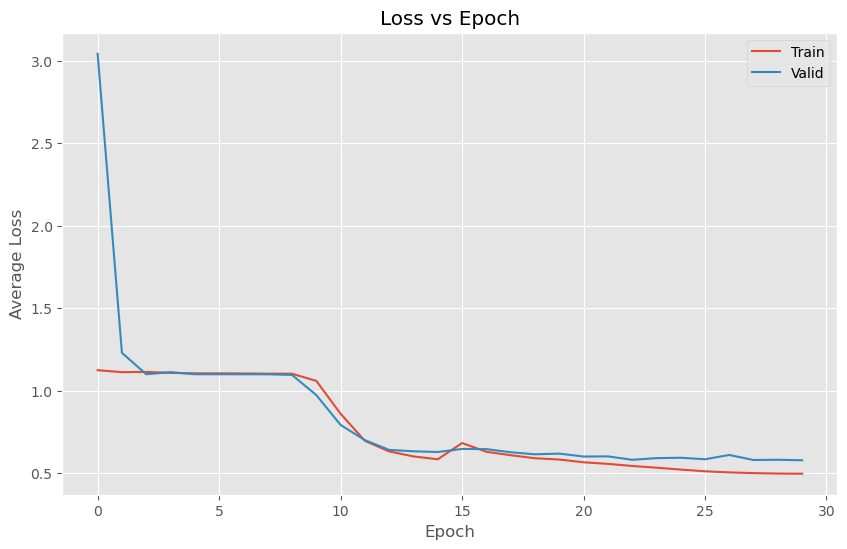

In [31]:
# Plot losses
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.title('Loss vs Epoch')
plt.show()

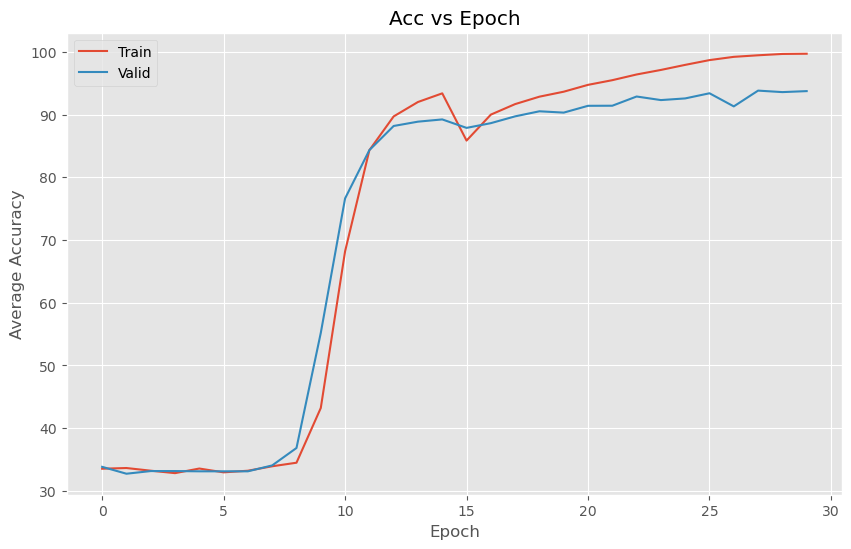

In [41]:
# Plot accuracy
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.legend()
plt.title('Acc vs Epoch')
plt.show()

### Evaluation

Testing Loop

In [33]:
def test_model(model,
                dataloader,
                dataset_size):
    
    model.eval()
    
    criterion = nn.CrossEntropyLoss()
    
    test_acc = []
    test_loss = []
    
    preds_list = []
    preds_probs_list = []
    labels_list = []
    
    y_scores = []
        
    with torch.no_grad():
            
            for batch in tqdm(dataloader):
                inputs, labels = batch[0], batch[1].squeeze()
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.int64)
                
                labels_list.append(labels.detach().cpu().numpy())
                
                outputs = model(inputs)
                softmax_outputs = torch.log_softmax(outputs, dim = 1)
                preds_probs_list.append(torch.softmax(outputs, dim = 1).detach().cpu().numpy())
                _, out_labels = torch.max(softmax_outputs, dim = 1)
                preds_list.append(out_labels.detach().cpu().numpy())
                
                y_scores += [torch.softmax(outputs, 1).detach().cpu()]
                
                acc = calculate_accuracy(labels = labels, logits = outputs)
                loss = criterion(outputs, labels)

                test_acc.append(acc)
                test_loss.append(loss.cpu().detach().numpy())
                
            y_scores = torch.cat(y_scores).cpu().numpy()
              
    print(f"Total Test Loss: {sum(test_loss) / dataset_size} ---- Total Test Accuracy: {sum(test_acc) / dataset_size}")
    
    return y_scores, preds_list, preds_probs_list, labels_list, np.mean(test_loss), np.mean(test_acc)

In [34]:
y_scores, preds_list, preds_probs_list, labels_list, test_loss, test_acc = test_model(new_model, test_dl, len(test_dl))

100%|██████████| 47/47 [00:08<00:00,  5.40it/s]

Total Test Loss: 0.25794999586774947 ---- Total Test Accuracy: 94.54787234042553


In [36]:
def flatten(my_list):
    flattened_list = [x for sublist in my_list for x in sublist]
    return flattened_list

Classification Report

In [37]:
print(classification_report(flatten(labels_list), flatten(preds_list),target_names = label_2_idx_dict))

              precision    recall  f1-score   support

          no       0.94      0.96      0.95      1017
        vort       0.96      0.96      0.96       969
      sphere       0.94      0.92      0.93      1014

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



ROC AUC Score

In [38]:
print(roc_auc_score(flatten(labels_list), flatten(preds_probs_list), average='macro', multi_class="ovr"))
print(roc_auc_score(flatten(labels_list), flatten(preds_probs_list), average='macro', multi_class="ovo"))

0.9843827760224548
0.9844256748555497


In [39]:
## The label_binarize function from the scikit-learn library converts a list of labels (labels_list) into a one-hot encoded format.
y_test = label_binarize(flatten(labels_list), classes = [0, 1, 2])

ROC Curve

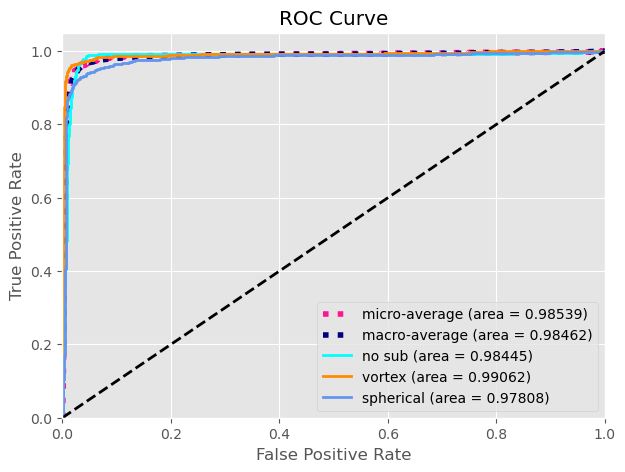

In [42]:
## y_scores -> Model Predictions
## y_test -> True Labels

## Code taken from https://github.com/ML4SCI/ML4SCIHackathon/blob/main/GravitationalLensingChallenge/StrongLensingChallenge-Classification.ipynb

n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_scores[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.rcParams['figure.figsize'] = [7, 5]
lw = 2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {})'
               ''.format(round(roc_auc["micro"],5)),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {})'
               ''.format(round(roc_auc["macro"],5)),
         color='navy', linestyle=':', linewidth=4)

labels = ['no sub', 'vortex', 'spherical']
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{} (area = {})'
             ''.format(labels[i], round(roc_auc[i],5)))

# Plot the ROC 
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", prop={"size":10})
plt.savefig('CommonTest-1_ROC-Curve.png')
plt.show()